In [1]:
import sys
import numpy as np

sys.path.insert(0, "..")

# Agents
from src.agents.robust_lin_exp3 import RobustLinExp3Agent

# Adversaries
from src.adversaries.adversary import Adversary
from src.adversaries.linear_adversary import LinearAdversary

# Contexts
from src.contexts.context import Context
from src.contexts.gaussian_context import GaussianContext

# Environments
from src.environments.environment import Environment
from src.environments.adversarial_contextual_env import AdversarialContextualEnv

# Adversarial Contextual MAB bandits
from src.adversarial_contextual_mab import AdversarialContextualMAB

# Display
from src.display.visualization import Visualization as vis

In [4]:
# Init Context
num_ctx = 5
d = 3
ctx = GaussianContext(n_contexts=num_ctx, n_features=d)

# Init Adversary
K = 10
h = 10000
noise_std = 0.1
noise_mean = 0.0
adv = LinearAdversary(num_actions=K, context_dim=d, horizon=h, noise_mean=noise_mean, noise_std=noise_std)

# Init Agent
lr = h**(-2/3)*(K*d)**(-1/3)*np.log(K)**(2/3)
exploration_rate = h**(-1/3)*(K*d*np.log(K))**(1/3)
sigma = ctx.estimate_sigma(n_samples=10000)
ag = RobustLinExp3Agent(name="RobustLinExp3", K=K, d=d, sigma=sigma, eta=lr, gamma=exploration_rate, epsilon=noise_mean) 

# Init Environment
adv_env = AdversarialContextualEnv(adversary=adv, context=ctx)

In [5]:
# Play experiment
num_sim = 100
exp = AdversarialContextualMAB()
(rewards, 
 regrets, 
 avg_rewards, 
 pseudo_regrets, 
 cumulative_regrets, 
 cumulative_pseudo_regrets) = exp.play(agent=ag, environment=adv_env, num_sim=num_sim, horizon=h)

In [6]:
bound_per_timestep = np.array([ag.compute_regret_bound(t) for t in range(h)])

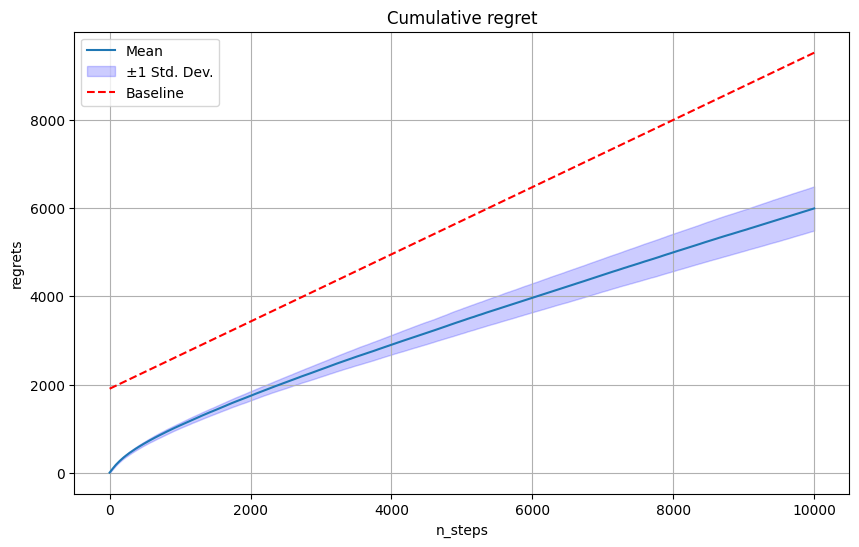

In [7]:
vis.plot_mean_std(
    data=cumulative_regrets, 
    title="Cumulative regret", 
    xlabel="n_steps", 
    ylabel="regrets", 
    baseline=bound_per_timestep,
)